# [E-04] 프로젝트 : 나의 첫 번째 캐글 경진대회

<br>

---

### ✔️ 필요한 라이브러리 import하기

---

In [248]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

---
### ✔️ 데이터 경로 지정 및 불러오기

---

In [249]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print(f'train 데이터셋 Shape : {train.shape}')
print(f'test 데이터셋 Shape : {test.shape}')

train 데이터셋 Shape : (15035, 21)
test 데이터셋 Shape : (6468, 20)


<br>Data는 `train.csv`와 `test.csv` 그리고 `sample_submission.csv` 촏 3개의 파일로 구성된다.<br>
- `train.csv`는 모델 학습용 파일로써 15035개의 Sample 데이터가 있고, feature 데이터에는 우리가 예측해야 할 집 가격 특성값이 포함되어 21개의 데이터가 존재한다.<br><br>
- `test.csv`는 테스트용 파일로써 6468개의 Sample 데이터, 그리고 20개의 feature가 존재한다.(집값 특성값인 price는 제외)<br><br>
- `sample_submission.csv`는 제출용 파일로써 kaggle `2019 2nd ML month with KAKR` - House price prediction leaderboard에 제출 시 맞춰야 하는 형식의 Sample csv 파일이다.<br>

---
### ✔️ 데이터 살펴보기

---

pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴본다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 주차 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

In [250]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


---
참고 : 데이터 설명 부분은 <U>[SeaOtter](https://www.kaggle.com/code/chocozzz/house-price-prediction-eda-updated-2019-03-12)</U>님의 커널을 참고하였다.<br><br>
- date의 경우 yyyy-mm-dd + T000000의 형태로 구성되어 있는데 필요한 부분인 6자리(년,월)만 추출하여 저장<br><br>
- bathrooms의 경우 소수점의 값이 보이는데, 미국은 화장실을 세는 단위가 아래와 같다.<br>(agit [공통] 와글와글 임새란/대전3기님이 공유해주신 내용 中)<br><br>
    - 0.5 : 세면대, 화장실
    - 0.75 : 세면대, 화장실, 샤워실
    - 1 : 세면대, 화장실, 샤워실, 욕조
    - 2.5 (세면대, 화장실, 샤워실, 욕조) * 2ea + (세면대, 화장실)<br><br>
- yr_renovated의 경우 -의 값이 보이는데, 0년도에 재건축이 되었다는 의미가 아니라 재건축을 하지 않았다는 의미
---

In [251]:
train.drop(['id'], axis=1,inplace=True)
train.head(5)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [252]:
test.drop(['id'], axis=1,inplace=True)
test.head(5)

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [253]:
train['date'] = train['date'].apply(lambda x:str(x[:6])).astype(int)
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   price          15035 non-null  float64
 2   bedrooms       15035 non-null  int64  
 3   bathrooms      15035 non-null  float64
 4   sqft_living    15035 non-null  int64  
 5   sqft_lot       15035 non-null  int64  
 6   floors         15035 non-null  float64
 7   waterfront     15035 non-null  int64  
 8   view           15035 non-null  int64  
 9   condition      15035 non-null  int64  
 10  grade          15035 non-null  int64  
 11  sqft_above     15035 non-null  int64  
 12  sqft_basement  15035 non-null  int64  
 13  yr_built       15035 non-null  int64  
 14  yr_renovated   15035 non-null  int64  
 15  zipcode        15035 non-null  int64  
 16  lat            15035 non-null  float64
 17  long           15035 non-null  float64
 18  sqft_l

In [254]:
test['date'] = test['date'].apply(lambda x:str(x[:6])).astype(int)
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           6468 non-null   int64  
 1   bedrooms       6468 non-null   int64  
 2   bathrooms      6468 non-null   float64
 3   sqft_living    6468 non-null   int64  
 4   sqft_lot       6468 non-null   int64  
 5   floors         6468 non-null   float64
 6   waterfront     6468 non-null   int64  
 7   view           6468 non-null   int64  
 8   condition      6468 non-null   int64  
 9   grade          6468 non-null   int64  
 10  sqft_above     6468 non-null   int64  
 11  sqft_basement  6468 non-null   int64  
 12  yr_built       6468 non-null   int64  
 13  yr_renovated   6468 non-null   int64  
 14  zipcode        6468 non-null   int64  
 15  lat            6468 non-null   float64
 16  long           6468 non-null   float64
 17  sqft_living15  6468 non-null   int64  
 18  sqft_lot

<br>1) train, test 데이터셋의 `date` 피처를 가공하여 6자리 숫자를 갖는(년,월) int형 변수로 변환하였다.<br>2) 집값을 예측하는데 필요없는 피쳐인 id 열은 삭제하였다.<br><br>이로써 데이터의 모든 피쳐들의 자료형은 수치형 데이터를 갖게된다.<br><br><br>

---
### ✔️ 데이터 탐색해보기(EDA)

---


**1) Target 변수(price)**<br>
- price의 경우 *집을 구매한 시점*의 가격이다. 즉, 현재의 가격을 반영하는게 아니다.<br>집을 산 이후 리모델링을 통해 집을 고치면 집의 가격에는 영향을 주지 못한다.<br><br>

참고 : https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/discussion/83957<br><br>

In [255]:
train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

△ price 정보의 경우 최대/최소 값의 차이가 크고, std(표준편차) 또한 굉장히 큰 편이다.<br>seaborn의 **kde(확률밀도그래프)**를 통해 <U>데이터의 분포</U>를 확인해보자<br><br>

<AxesSubplot:xlabel='price', ylabel='Density'>

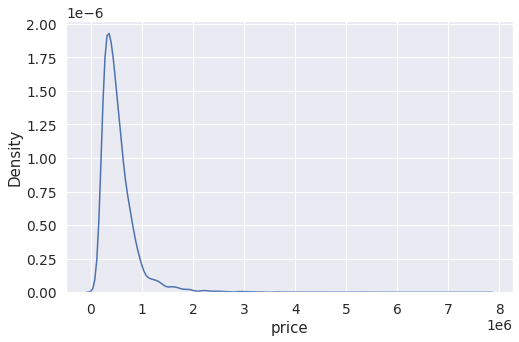

In [256]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.kdeplot(train['price'], ax=ax)

회귀문제에서 데이터를 잘 fitting 하기 위해서는 데이터는 정규분포를 따라야한다.<br><br>**따라서 Target 값인 price 값들이 정규분포를 갖도록 하기위해 Normalization(log)을 진행한다.**<br><br>

<AxesSubplot:xlabel='price', ylabel='Density'>

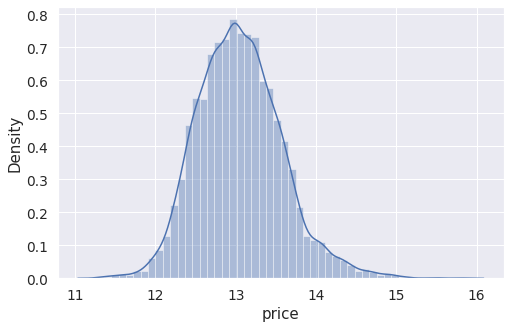

In [257]:
train['price'] = np.log1p(train['price'])

fig, ax = plt.subplots(figsize=(8,5))
sns.distplot(train['price'])

<br>**2) 데이터 간 상관관계 분석**<br>

- 피어슨 상관관계 : 연속형 변수에 사용
- 스피어만 순위 상관관계 : 범주형 변수도 포함되었을 경우에 사용<br><br>

아래는 Target변수인 price와 가장 상관관계가 높은 순서대로 본 히트맵이다.<br>21개의 데이터를 전부 보는 것이 아닌라 분석의 편의를 위해 상관도가 높은 상위 10개의 값만 보도록 한다.<br><br>
참고 : https://www.kaggle.com/code/chocozzz/house-price-prediction-eda-updated-2019-03-12

In [258]:
import scipy as sp

data_cor = train.corr(method='spearman')
data_cor_col10 = data_cor.nlargest(n=10, columns='price').index
# price와 correlation이 높은 column 10개 뽑기

cor = np.array(sp.stats.spearmanr(train[data_cor_col10].values))[0] # 10 x 10

In [259]:
print(data_cor_col10.values)

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

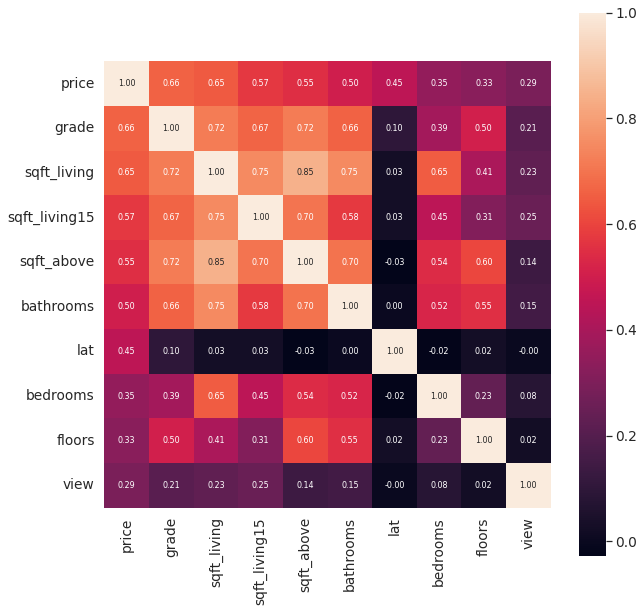

In [260]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,
            xticklabels=data_cor_col10.values, yticklabels=data_cor_col10.values)

Target 변수인 `price`와 상관도가 높은 변수는 집등급 - 주거공간의 크기 - 전체 크기순이다. <br><br>

**여기서 특이한 점은 재밋게도 lat이라는 위도 값이 `price`와의 상관도가 높은 것을 볼 수 있다.**
> [Discussion](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/discussion/83549)에 따르면, 위의 지역은 시애틀인데 시애틀은 북쪽으로 갈 수록 살기 좋은 집들이 많다고 한다. 이를 근거했을 때 위도가 높을 수록 살기 좋은 집이 많을 거라는 예측이 가능하다.

<br><br>

<br>**3) 데이터 전처리 - 이상치(Outlier) 제거**<br><br>


In [261]:
col_sel = ['grade', 'sqft_living', 'sqft_living15', 'sqft_above', 'bathrooms', 'lat', 'bedrooms', 'floors', 'view']
print('< unique한 요소 갯수 > ')
print()
for col in col_sel:
    print('{} : {}'.format(col, len(train[col].value_counts())))

< unique한 요소 갯수 > 

grade : 12
sqft_living : 863
sqft_living15 : 682
sqft_above : 789
bathrooms : 29
lat : 4692
bedrooms : 11
floors : 6
view : 5


<br>△ 상관도가 높은 변수들의 요소별 unique한 갯수는 위의 자료와 같다.<br><br>각 변수들과 `price`와의 관계를 그래프로 시각화해서 살펴보자<br>
- unique한 요소가 많은 변수들은추세선(regplot)을 적은 변수들은 boxplot을 사용한다.<br><br>

<br>

---
**1) 📊 Price - Grade**<br>

---

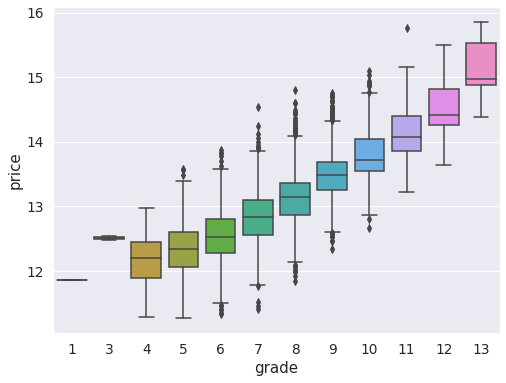

In [262]:
data = pd.concat([train['price'], train['grade']], axis=1)
fig, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

<br>전체적인 데이터의 경향으로 봤을 때, `grade == 3` 일때는 `price`의 가격이 튀는 outlier로 판단하여 제거한다.<br><br>

In [263]:
del_row = train[train['grade']==3].index.values
print('del_row : {}'.format(del_row))
print(f'train.shape : {train.shape}')

del_row : [2302 4123]
train.shape : (15035, 20)


In [264]:
train.drop(index=del_row, inplace=True)
print(f'train.shape : {train.shape}')

train.shape : (15033, 20)


△ `grade == 3`에 해당하는 2개의 데이터를 포함하는 행 삭제

<br>

---
**2) 📊 Price - sqrt_living**<br>

---

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

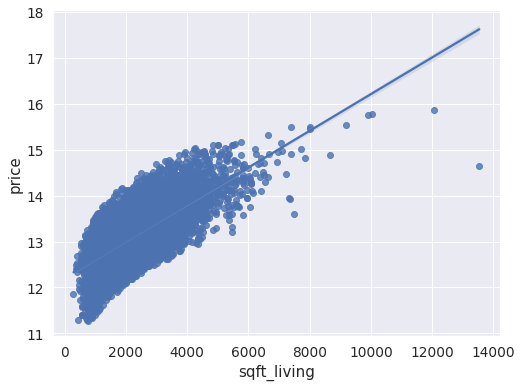

In [265]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.regplot(train['sqft_living'], train['price'])


△ 전반적으로 주거공간이 넓어질 수록 집값이 상승하지만 주거공간이 14000인 부근에서의 값은 이상치로 판단되어 제거한다.

In [266]:
del_row = train[train['sqft_living'] > 12500].index.values
print('del_row : {}'.format(del_row))
print(f'train.shape : {train.shape}')

del_row : [8912]
train.shape : (15033, 20)


In [267]:
train.drop(index=del_row, inplace=True)
print(f'train.shape : {train.shape}')

train.shape : (15032, 20)


△ `sqft_living > 12500`에 해당하는 1개의 데이터를 포함하는 행 삭제

<br>

---
**3) 📊 Price - sqrt_living15**<br>

---

<AxesSubplot:xlabel='sqft_living15', ylabel='price'>

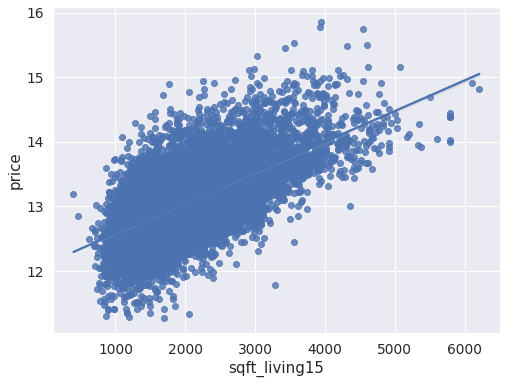

In [268]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.regplot(train['sqft_living15'], train['price'])


△ sqft_living15의 경우 15년도를 기준으로 하다보니, sqft_living에 비해 분산은 크지만 outlier 제거는 불필요하다고 판단

<br>

---
**4) 📊 Price - sqft_above**<br>

---

<AxesSubplot:xlabel='sqft_above', ylabel='price'>

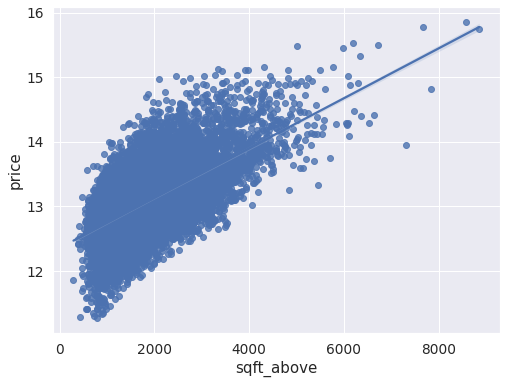

In [269]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.regplot(train['sqft_above'], train['price'])


△ 이상치 제거 불핊요

<br>

---
**5) 📊 Price - bathrooms**<br>

---

<AxesSubplot:xlabel='bathrooms', ylabel='price'>

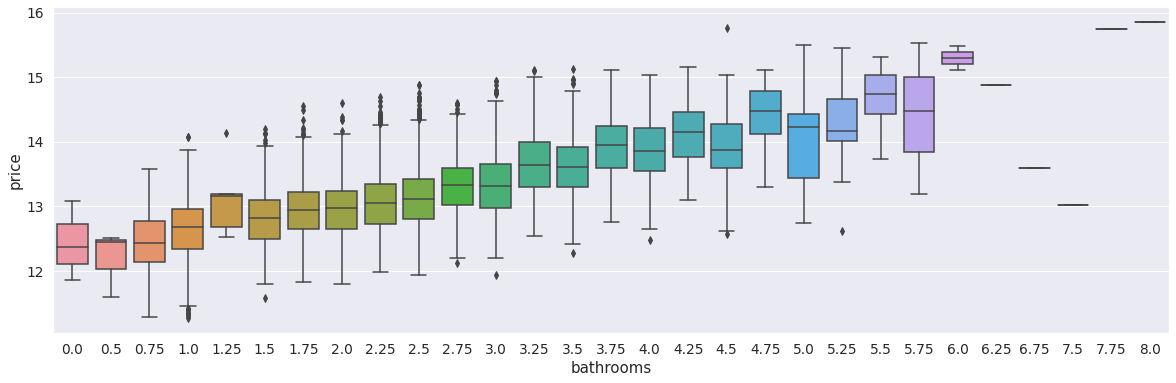

In [270]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.boxplot(train['bathrooms'], train['price'])


<br>△ bathrooms이 증가할수록 가격은 양의 상관관계를 보이고 있다.<br>`bathroom == [6.0 6.25 6.75 7.5]`인 경우 이상치로 판단하고 제거<br><br>

In [271]:
del_row = train[(train['bathrooms'] <7.75) & (train['bathrooms'] >= 6.0)].index.values
print('del_row : {}'.format(del_row))
print(f'train.shape : {train.shape}')

del_row : [  947  2859  5990 10152 13311]
train.shape : (15032, 20)


In [272]:
train.drop(index=del_row, inplace=True)
print(f'train.shape : {train.shape}')

train.shape : (15027, 20)


△ `bathrooms가 6.0 이상 7.5 미만`에 해당하는 5개의 데이터를 포함하는 행 삭제

<br>

---
**6) 📊 Price - lat**<br>

---

<AxesSubplot:xlabel='lat', ylabel='price'>

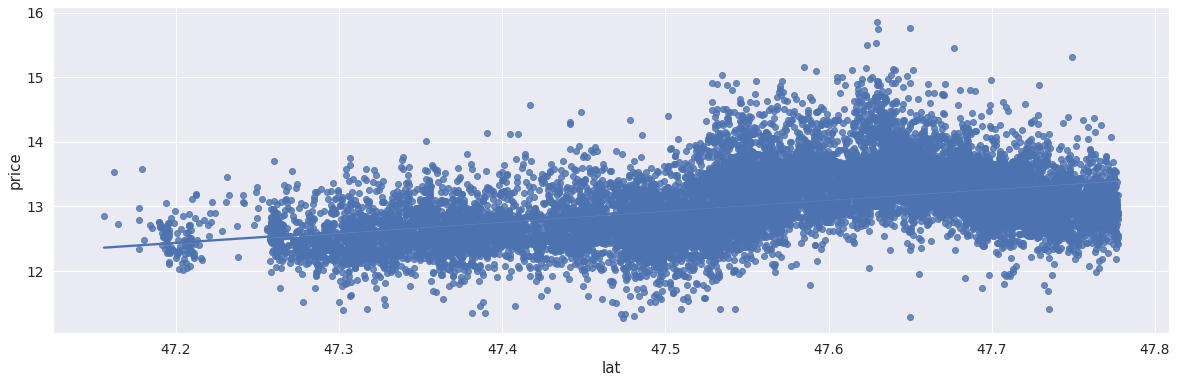

In [273]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.regplot(train['lat'], train['price'])


<br>△ 이상치 제거 불필요

<br>

---
**7) 📊 Price - bedrooms**<br>

---

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

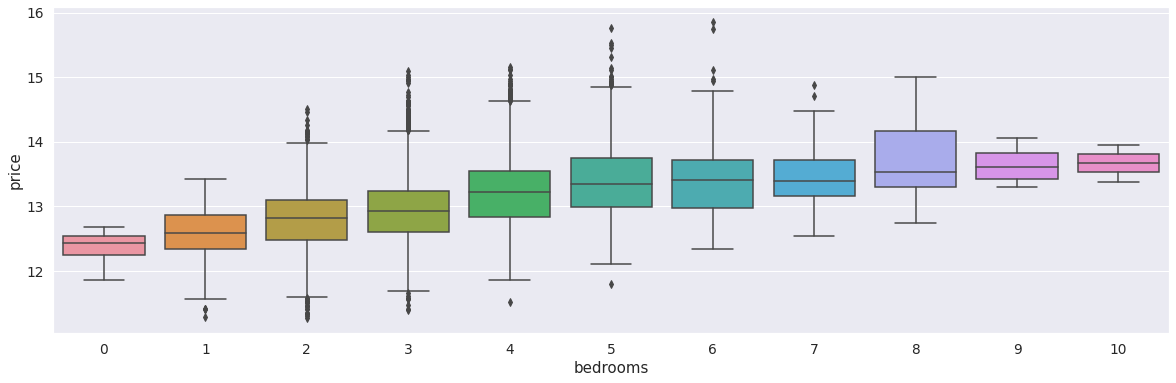

In [274]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.boxplot(train['bedrooms'], train['price'])


<br>△ bedrooms가 2\~6 범위에서 분산이 매우 크게 나타난다. 2\~6범위의 값들은 하지만 밀도가 높게 형성되어 있어 다른 변수들의 영향이 크기 때문에 제거하지 않는다.<br><br>

<br>

---
**8) 📊 Price - floors**<br>

---

<AxesSubplot:xlabel='floors', ylabel='price'>

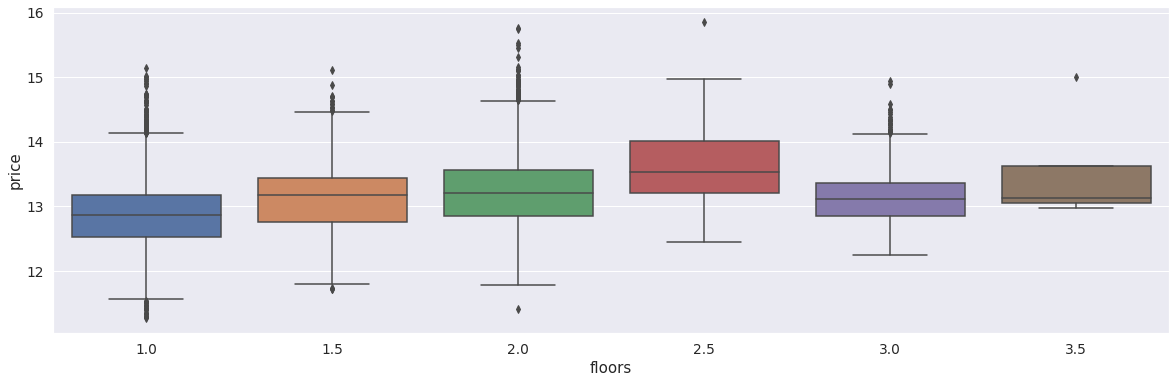

In [275]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.boxplot(train['floors'], train['price'])


<br>△ 이상치 제거 불필요

<br>

---
**9) 📊 Price - view**<br>

---

<AxesSubplot:xlabel='view', ylabel='price'>

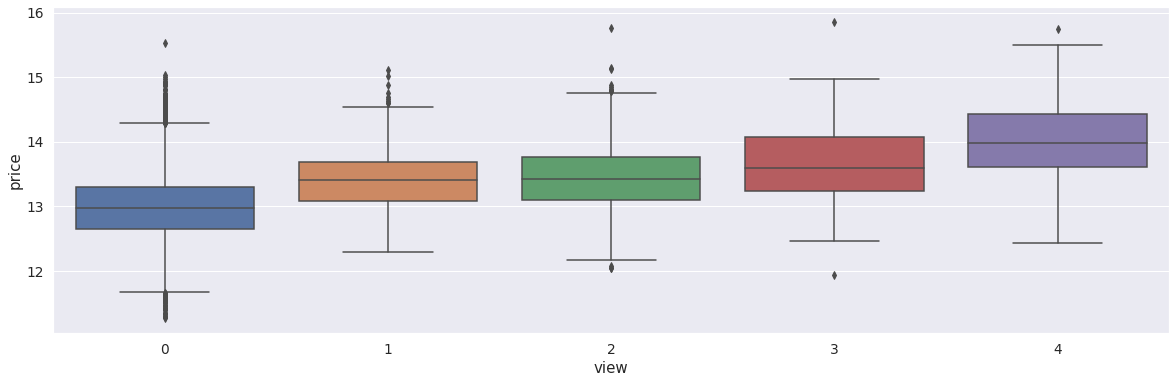

In [276]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.boxplot(train['view'], train['price'])


<br>△ 이상치 제거 불필요<br><br>

<br>**4) 정규화(피처들의 분포 확인)**<br><br>


In [277]:
columns = train.columns
len(columns)

20

In [278]:
columns[1]

'price'

IndexError: index 9 is out of bounds for axis 0 with size 9

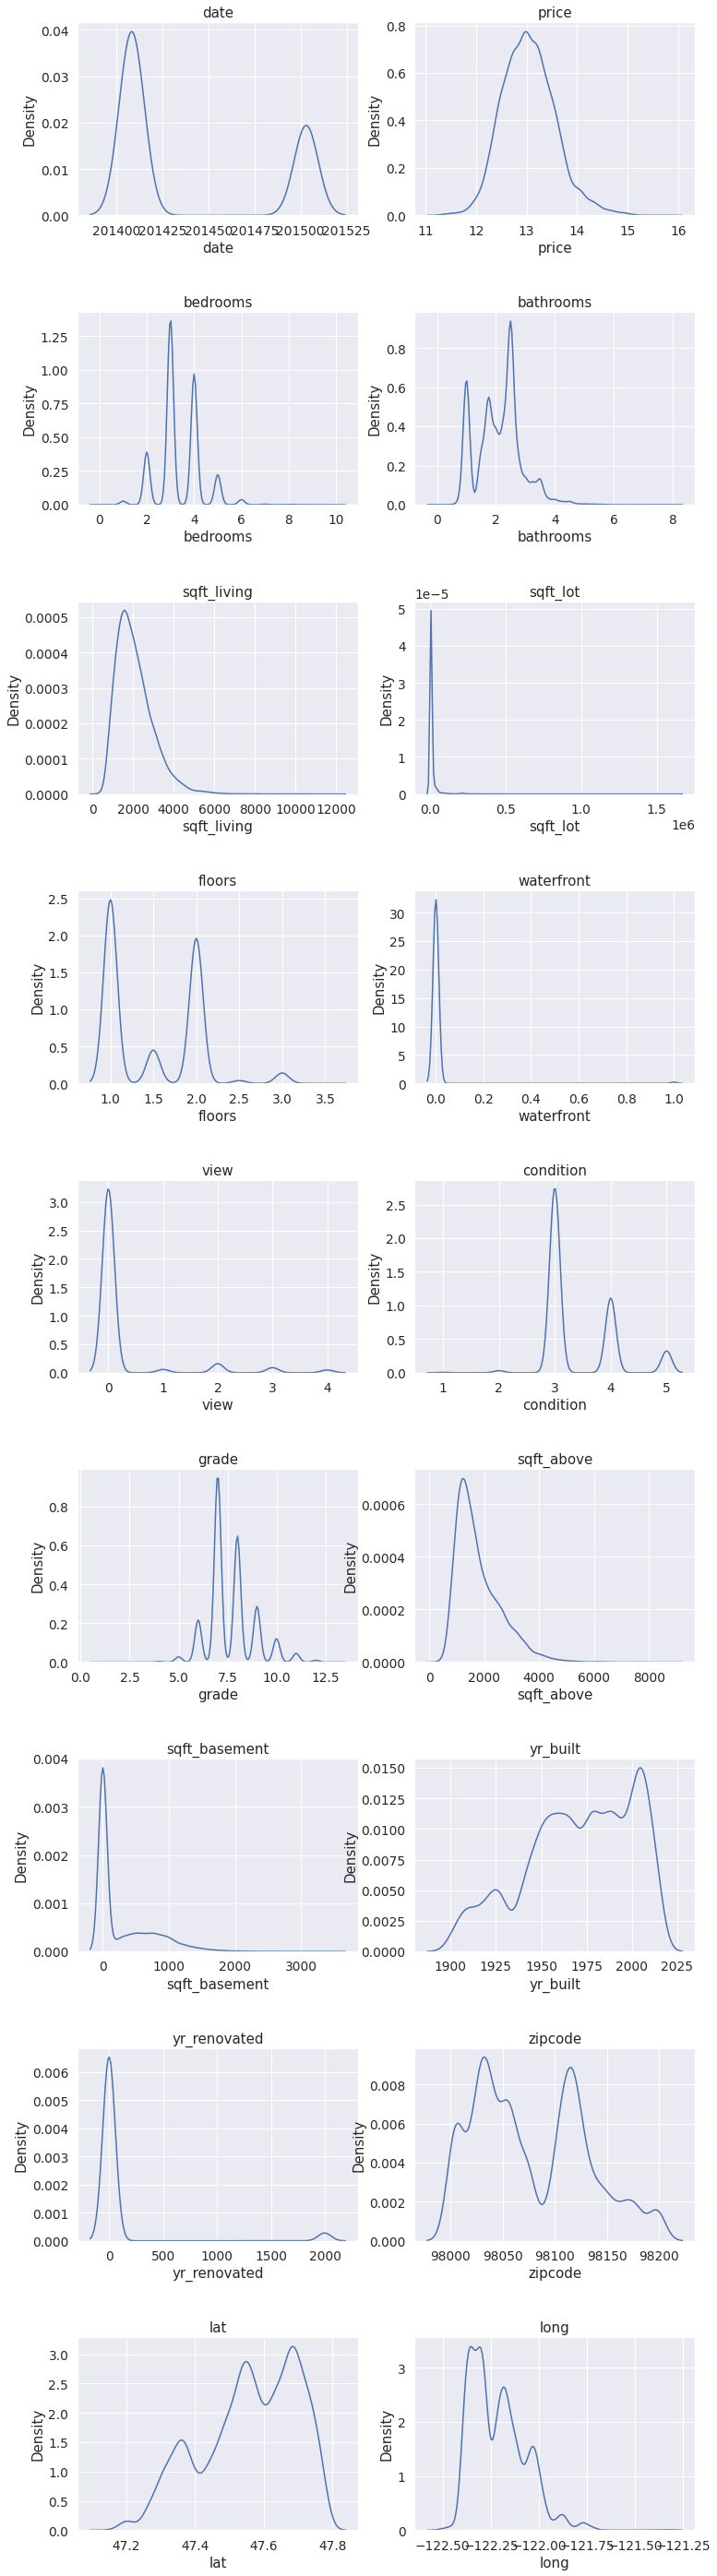

In [279]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 
fig.subplots_adjust(hspace=0.5)


# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 0
columns = train.columns
for row in range(10):
    for col in range(2):
        
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 20:
            break

△ price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보인다.<br><br> log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보자.<br><br>

In [280]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

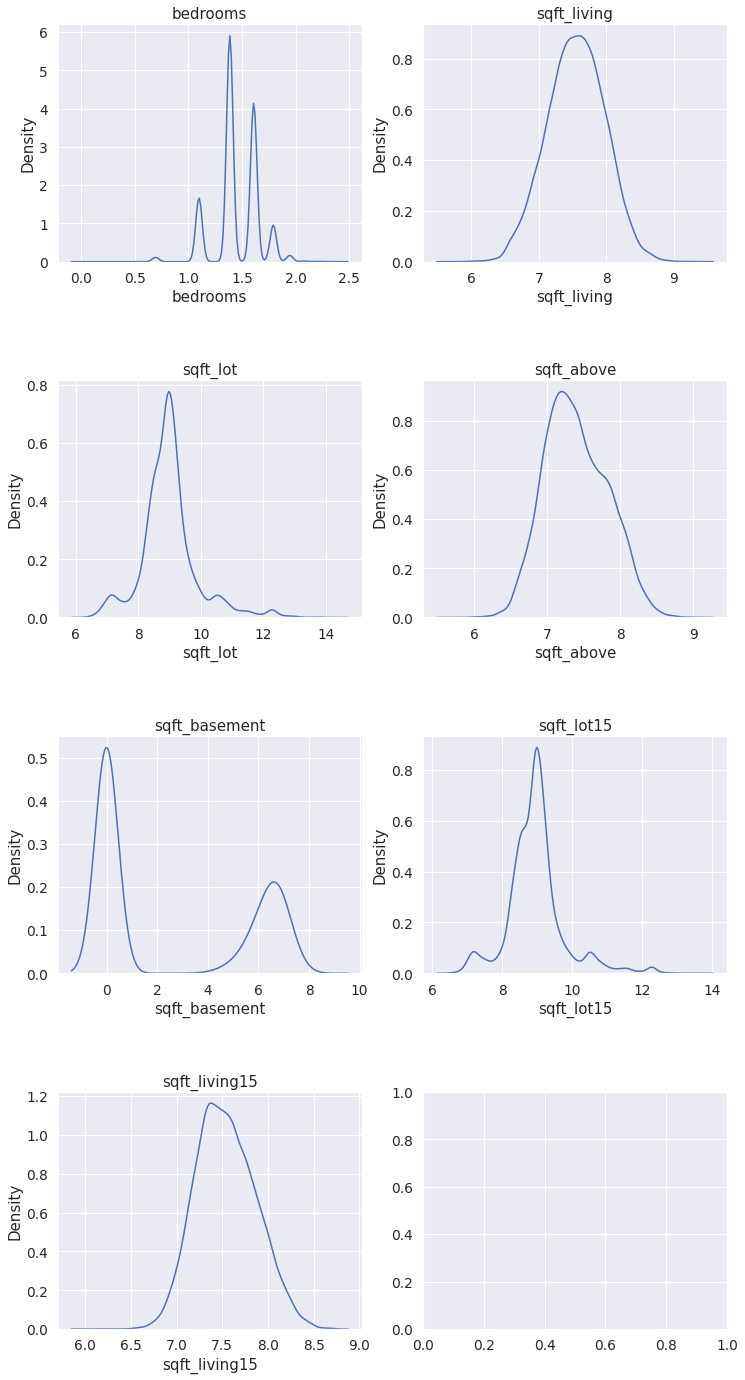

In [281]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

fig.subplots_adjust(hspace=0.5)

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

<br>

---
### ✔️ train 데이터셋 target 변수(price) 분리하기
---

In [282]:
y = train['price']
print(y)

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15027, dtype: float64


In [283]:
train = train.drop(columns = ['price'], axis=1)
train.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

<br><br>

---
### ✔️ 다양한 실험을 위해 함수로 만들어 쓰자

---

**1) RMSE 계산**<br><br>

In [307]:
# 데이터셋을 훈련 데이터 셋과 검증 데이터셋으로 나누기 위한 train_test_split 함수와.
# RMSE 점수를 계산하기 위한 mean_squared_error를 가져온다.

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

<br>대회에서 점수를 매기는 것과 같은 평가 척도인 RMSE<br>주의할 점, `y_test`나 `y_pred`는 위에서 `np.log1p()`로 변환된 값이기 때문에 원래 데이터 단위에 맞게 되돌리기 위해 `np.expm1()`을 추가해야 한다.<br><br>

In [308]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

<br>**✔️ `XGBRegressor`, `LGNMRegressor`, `GradientBoostingRegressor`, `RandomForestRegressor` 네가지 모델을 가져와보자.**<br><br>

In [312]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [313]:
# 학습모델 인스턴스를 생성 후 `models`라는 리스트에 넣어준다.
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 

#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [302]:
# 각 모델의 이름은 다음과 같이 클래스의 __name__ 속성에 접근해서 얻을 수 있다.

print(gboost.__class__.__name__)
print(xgboost.__class__.__name__)
print(lightgbm.__class__.__name__)
print(rdforest.__class__.__name__)

GradientBoostingRegressor
XGBRegressor
LGBMRegressor
RandomForestRegressor


In [289]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [290]:
score_df = get_scores(models, train, y)
score_df

,RMSE
GradientBoostingRegressor,149650.843602
RandomForestRegressor,146399.307539
LGBMRegressor,141555.573783
XGBRegressor,139532.073932


<br><br>

---
### ✔️ 하이퍼 파라미터 튜닝의 최강자, 그리드 탐색

---


<br>이제 모델과 데이터셋이 있다면 RMSE를 계산해주는 함수가 준비되었으니, 다양한 하이퍼 파라미터로 실험하는 일이 남았다.<br>실험은 `sklearn.model_selection` 라이브러리 안에 있는 `GridSearCV`클래스를 활용한다.<br><br>

In [291]:
from sklearn.model_selection import GridSearchCV

`GridSearchCV`에 입력되는 인자는 다음과 같다<br>
- `estimator` : 학습할 모델(Classifier, Regressor, Pipeline 등)
- `param_grid` : 탐색할 파라미터의 종류(딕셔너리로 입력)
- `scoring` : 모델의 성능을 평가할 지표
- `cv` :  cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
- `verbose` : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양(숫자가 클수록 더 많은 메세지를 출력한다.)
- `n_jobs` : 그리드 탐색을 진행하면서 사용할 cpu 갯수

<br>**4개의 모델에 대하여 param_grid 설정**<br><br>
① GradientBoostingRegressor<br>
② XGBRegressor<br>
③ LGBMRegressor<br>
④ RandomForestRegressor<br>
<br><br>

In [388]:
params = [
    {'n_estimators':[50, 100], 'max_depth':[1,10]}, # GradientBoostingRegressor
         
    {'n_estimators':[100], 'max_depth':[10]}, # XGBRegressor

    {'n_estimators':[50, 100, 500, 700, 1000], 'max_depth':[5,10]}, # LGBMRegressor

    {'n_estimators':[50, 100], 'max_depth':[1,10]}] # RandomForestRegressor

params

[{'n_estimators': [50, 100], 'max_depth': [1, 10]},
 {'n_estimators': [100], 'max_depth': [10]},
 {'n_estimators': [50, 100, 500, 700, 1000], 'max_depth': [5, 10]},
 {'n_estimators': [50, 100], 'max_depth': [1, 10]}]

<br>`model`, `param_grid`와 함께 여러 인자를 넣어서 `GridSearchCV`를 수행하자<br><br>
- grid model을 GridSearchCV로 초기화하고 train과 y 데이터로 모델을 간단히 학습하면 param_grid 내의 <br>모든 하이퍼 파라미터의 조합에 대해 실험이 완료된다.

In [389]:
trained_model = []

for i in range(4):
    grid_model = GridSearchCV(models[i], param_grid=params[i],
                             scoring='neg_mean_squared_error',
                             cv=5, verbose=1, n_jobs=5)
    grid_model.fit(train, y)
    trained_model.append(grid_model)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [390]:
trained_model

[GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=2020),
              n_jobs=5,
              param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
              scoring='neg_mean_squared_error', verbose=1),
 GridSearchCV(cv=5,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_pa

In [391]:
params = []
score = []

for i in range(4):
    # 결과값 저장
    params.extend(trained_model[i].cv_results_['params'])
    score.extend(trained_model[i].cv_results_['mean_test_score'])
    

In [392]:
m_names = ['GradientBoostingRegressor']*4 
m_names.extend(['XGBRegressor']*1)
m_names.extend(['LGBMRegressor']*10)
m_names.extend(['RandomForestRegressor']*4)

results = pd.DataFrame(data=params)
results['score'] = score
results['model_names'] = m_names
results['RMSLE'] = np.sqrt(-1*results['score'])
results = results[['model_names', 'max_depth', 'n_estimators', 'score', 'RMSLE']]
results.sort_values('RMSLE', inplace=True)
results

,model_names,max_depth,n_estimators,score,RMSLE
12,LGBMRegressor,10,500,-0.026273,0.162090
13,LGBMRegressor,10,700,-0.026431,0.162576
7,LGBMRegressor,5,500,-0.026499,0.162786
8,LGBMRegressor,5,700,-0.026577,0.163025
14,LGBMRegressor,10,1000,-0.026700,0.163401
9,LGBMRegressor,5,1000,-0.026800,0.163706
11,LGBMRegressor,10,100,-0.027074,0.164541
6,LGBMRegressor,5,100,-0.028747,0.169549
10,LGBMRegressor,10,50,-0.029299,0.171169
3,GradientBoostingRegressor,10,100,-0.029636,0.172151


<br><br>

---
### ✔️ 제출하는 것도, 빠르고 깔끔하게!

---

△ 가장 좋은 조합은 `max_depth=10`, `n_estimators=500`이다.<br>해당 모델로 학습을 해서 예측값인 `submission.csv` 파일을 만들어서 제출해보자<br><br>

In [393]:
# 먼저 해당 파라미터로 구성된 모델을 준비하고, 학습 후 예측 결과를 생성한다.

model = LGBMRegressor(max_depth=10, n_estimators=500, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction


array([13.16503159, 13.05290197, 14.00164006, ..., 13.11397724,
       12.6877555 , 12.97943134])

In [394]:
prediction = np.expm1(prediction)
prediction

array([ 521794.79517047,  466447.06711592, 1204577.24110408, ...,
        495823.46294886,  323758.26203905,  433405.4877454 ])

In [395]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = prediction

kakr_submission_dir  = os.getenv('HOME')+'/aiffel/Exploration/Ex4'

my_submission_csv_path = '{}/submission_{}_RMSLE_{}'.format(kakr_submission_dir, 'lgbm', '0.1621')

submission.to_csv(my_submission_csv_path, index=False)

print('{} saved!'.format(my_submission_csv_path))

/aiffel/aiffel/Exploration/Ex4/submission_lgbm_RMSLE_0.1621 saved!


<br><br>

---
### ✔️ 결론

---

![image](https://user-images.githubusercontent.com/103712369/167634628-b19c86dc-4843-4eee-bd2f-191b81b00d31.png)


- 이번 Exploration Node #4 `집값예측하기`는 여태까지 배운 Machine Learning의 총 집합체였던것 같다. Kaggle 대회에서 진행되었던 competition 문제를 직접 불러오는 것부터 데이터를 하나하나 살펴보고, 데이터 전처리 작업(Feature Engineering)을 진행하고, 모델을 학습하는데, 성능이 좋은 단일모델을 사용하는게 아니라 Ensemble 기법까지 적용해서 A-Z 과정을 모두 수행해보았다.<br><br>
- 데이터에서 피처는 총 21개, Sample수는 15000개정도로 구성되어 있어 많은 편은 아니였지만, 직접 Feature간의 상관관계도 분석해보고 heatmap을 사용하여 target 변수와 가장 관련성이 높은 변수들도 추출하여 보았다. 또한 결측치 분석 및 이상치(Outlier) 제거를 진행하여 Feature Engineering을 수행했는데, 결과가 크게 달라지진 않았다. 상위권을 달성한 커널등을 보며 데이터 분석을 다시 진행해보려한다.<br><br>
- ① GradientBoostingRegressor, ② XGBRegressor, ③ LGBMRegressor, ④ RandomForestRegressor 4개의 모델을 적용하여 학습을 진행하였고, Cross Validation을 진행할 때 5 fold 교차검증을 수행하였고, parameter_grid에서 여러가지 하이퍼 파라미터를 튜닝해보며 최적의 학습모델을 찾아보았다. <br>내가찾은 최적의 하이퍼 파라미터는 lgbm 모델을 사용했을 때, `max_depth=10`, `n_estimators=500` 일때가 가장 성능이 좋게 나온것 같다. 조금 더 많은 범위에서 최적의 하이퍼 파라미터를 튜닝했다면 좀 더 좋은 성능이 나왔을 테지만, 생각보다 xgboost 모델을 학습하는데 정말 오랜 시간이 걸려서, 이만 접기로 했다. 